In [5]:
import math


class MotionState:
    def __init__(self, pose, vel: float):
        self.pose = pose
        self.vel = vel


class Profile:
    def __init__(self, initial_state: MotionState, final_state: MotionState):
        self.initial_state = initial_state
        self.final_state = final_state
        self.pose_delta = final_state.pose - initial_state.pose


class Trapezoid(Profile):
    def get_time(self, max_vel, max_accel):
        d = self.pose_delta
        i_pose = self.initial_state.pose
        i_v = self.initial_state.vel
        f_v = self.final_state.vel

        # v = v0 + at
        # t = (v - v0) / a
        accel_t = (max_vel - i_v) / max_accel
        # d = v0t + 0.5at^2
        accel_d = i_v * accel_t + 0.5 * max_accel * accel_t**2
        # print("before accel d:", accel_d)
        # if not enough distance to accelerate to max velocity
        # recalculate max velocity constrained to half max distance
        if accel_d > (d / 2):
            # d = v0t + 0.5at^2
            # sqrt((d - v0t) / (0.5a)) = t
            accel_t = math.sqrt(((d / 2) - i_v * accel_t) / (0.5 * max_accel))
            accel_d = d / 2
            max_vel = max_accel * accel_t
            # print("new accel_t:", accel_t)

        # decel_t = accel_t
        # v = v0 + at
        # t = (v - v0) / a
        # decel_t = (f_v - max_vel) / max_accel
        decel_t = (max_vel - f_v) / max_accel
        # d = v0t + 0.5at^2
        decel_d = f_v * decel_t + 0.5 * max_accel * decel_t**2
    
        cruise_d = d - accel_d - decel_d
        cruise_t = cruise_d / max_vel

        total_profile_t = accel_t + cruise_t + decel_t
        return total_profile_t

    def calculate_distance(self, max_vel, max_accel, elapsed_time):
        d = self.pose_delta

        accel_t = max_vel / max_accel
        accel_d = 0.5 * max_accel * accel_t**2

        if accel_d > (d / 2):
            accel_t = math.sqrt((d / 2) / (0.5 * max_accel))
            accel_d = d / 2
            max_vel = max_accel * accel_t

        decel_t = accel_t

        cruise_d = d - 2 * accel_d
        cruise_t = cruise_d / max_vel

        total_profile_t = accel_t + cruise_t + decel_t

        decel_start = accel_t + cruise_t

        if elapsed_time > total_profile_t:
            return d

        if elapsed_time < accel_t:
            return 0.5 * max_accel * elapsed_time**2
        elif elapsed_time < decel_start:
            accel_d = 0.5 * max_accel * accel_t**2
            current_cruise_t = elapsed_time - accel_t
            return accel_d + max_vel * current_cruise_t
        else:
            accel_d = 0.5 * max_accel * accel_t**2
            cruise_d = max_vel * cruise_t
            decel_t = elapsed_time - decel_start

            return (
                accel_d + cruise_d + max_vel * decel_t - 0.5 * max_accel * decel_t**2
            )
         
    def calculate_distance_2(self, max_vel, max_accel, elapsed_time):
        d = self.pose_delta
        i_pose = self.initial_state.pose
        i_v = self.initial_state.vel
        f_v = self.final_state.vel

        # v = v0 + at
        # t = (v - v0) / a
        accel_t = (max_vel - i_v) / max_accel
        # d = v0t + 0.5at^2
        accel_d = i_v * accel_t + 0.5 * max_accel * accel_t**2
        
        # print("before accel d:", accel_d)
        # if not enough distance to accelerate to max velocity
        # recalculate max velocity constrained to half max distance
        if accel_d > (d / 2):
            # d = v0t + 0.5at^2
            # sqrt((d - v0t) / (0.5a)) = t
            accel_t = math.sqrt(((d / 2) - i_v * accel_t) / (0.5 * max_accel))
            accel_d = d / 2
            max_vel = max_accel * accel_t
            # i_v = max_vel
            # print("new accel_t:", accel_t)

        # decel_t = accel_t
        # v = v0 + at
        # t = (v - v0) / a
        # decel_t = abs(f_v - max_vel) / max_accel
        decel_t = (max_vel - f_v) / max_accel
        # d = v0t + 0.5at^2
        # decel_d = f_v * decel_t + 0.5 * max_accel * decel_t**2
        # d = t * (v + v0) / 2 
        decel_d = decel_t * (f_v + max_vel) / 2

        cruise_d = d - accel_d - decel_d
        cruise_t = cruise_d / max_vel

        total_profile_t = accel_t + cruise_t + decel_t

        decel_start = accel_t + cruise_t

        if elapsed_time > total_profile_t:
            return d + i_pose

        if elapsed_time < accel_t:
            print("accel:", i_v * elapsed_time + 0.5 * max_accel * elapsed_time**2 + i_pose) 
            # print("accel_d:", accel_d)
            return i_v * elapsed_time + 0.5 * max_accel * elapsed_time**2 + i_pose
        elif elapsed_time < decel_start:
            # accel_d = 0.5 * max_accel * accel_t**2
            current_cruise_t = elapsed_time - accel_t
            print("cruise:", accel_d + max_vel * current_cruise_t + i_pose)
            # print("accel_d:", accel_d)
            return accel_d + max_vel * current_cruise_t + i_pose
        else:
            # accel_d = 0.5 * max_accel * accel_t**2
            # cruise_d = max_vel * cruise_t
            decel_t = elapsed_time - decel_start
            print("decel:", accel_d + cruise_d + max_vel * decel_t - 0.5 * max_accel * decel_t**2 + i_pose)
            return (
                accel_d + cruise_d 
                + max_vel * decel_t
                - 0.5 * max_accel * decel_t**2
                + i_pose
            )
    
    def new_profile(self, max_vel, max_accel, elapsed_time):
        d = self.pose_delta
        v0 = self.initial_state.vel
        vf = self.final_state.vel

        # time / distance it would take to reach initial velocity
        i_accel_t = v0 / max_accel
        i_accel_d = 0.5 * max_accel * i_accel_t**2


        f_accel_t = vf / max_accel
        f_accel_d = 0.5 * max_accel * f_accel_t**2

        full_profile_d = i_accel_d + d + f_accel_d
        
        
        # t = v / a
        accel_t = max_vel / max_accel
        accel_d = 0.5 * max_accel * accel_t**2

        # multiply 2 because symmetric 
        max_speed_d = full_profile_d - (0.5 * max_accel * accel_t**2) * 2

        # if triangle
        if max_speed_d < 0:
            # d = v0t + 0.5at^2 * 2 (because triangle symmetric)
            # sqrt((d - v0t) / (0.5a)) = t
            
            accel_t = math.sqrt(full_profile_d / max_accel) 
            max_speed_d = 0
        


        if accel_d > (d / 2):

            # d = v0t + 0.5at^2
            # sqrt((d - v0t) / (0.5a)) = t
            accel_t = math.sqrt((d / 2) / (0.5 * max_accel))
            accel_d = d / 2
            max_vel = max_accel * accel_t
        
        decel_t = max_vel / max_accel
        decel_d = 0.5 * max_accel * decel_t**2
        
        cruise_d = d - accel_d - decel_d
        # t = d / v
        cruise_t = cruise_d / max_vel
        # d = t * (v + v0) / 2
        # 2d = t * (v + v0)
        # t = 2d / (v + v0)
        # cruise_t = (2 * cruise_d) / (max_vel) 

        # total_profile_t = accel_t + cruise_t + decel_t
        # if elapsed_time > total_profile_t:
        #     return d

        if elapsed_time < accel_t:
            # d = 0.5at^2
            return 0.5 * max_accel * elapsed_time**2
        elif elapsed_time < (accel_t + cruise_t):
            current_cruise_t = elapsed_time - accel_t
            return accel_d + current_cruise_t * max_vel
        elif elapsed_time > (accel_t + cruise_t):
            current_decel_t = elapsed_time - (accel_t + cruise_t)
            return accel_d + cruise_d + max_vel * current_decel_t + 0.5 * -max_accel * current_decel_t**2 
        else:
            return d

In [2]:
import matplotlib.pyplot as plt
import numpy as np

a = MotionState(0, 0)
b = MotionState(10, 0)
p = Trapezoid(a, b)

In [3]:
vel = 6
accel = 2

dt = 0.01
duration = p.get_time(vel, accel) 
time = np.linspace(0, duration, int(duration/dt))
# calculate_distance_2
calculated_distances = [p.calculate_distance_2(vel, accel, t) for t in time]

accel: 0.0
accel: 0.00010054495364877637
accel: 0.00040217981459510547
accel: 0.0009049045828389872
accel: 0.0016087192583804219
accel: 0.0025136238412194092
accel: 0.003619618331355949
accel: 0.004926702728790043
accel: 0.0064348770335216875
accel: 0.008144141245550884
accel: 0.010054495364877637
accel: 0.01216593939150194
accel: 0.014478473325423796
accel: 0.016992097166643204
accel: 0.01970681091516017
accel: 0.022622614570974683
accel: 0.02573950813408675
accel: 0.029057491604496367
accel: 0.032576564982203536
accel: 0.03629672826720827
accel: 0.04021798145951055
accel: 0.04434032455911037
accel: 0.04866375756600776
accel: 0.0531882804802027
accel: 0.057913893301695184
accel: 0.06284059603048522
accel: 0.06796838866657282
accel: 0.07329727120995795
accel: 0.07882724366064069
accel: 0.08455830601862094
accel: 0.09049045828389873
accel: 0.09662370045647409
accel: 0.102958032536347
accel: 0.10949345452351746
accel: 0.11622996641798547
accel: 0.12316756821975103
accel: 0.13030625992881

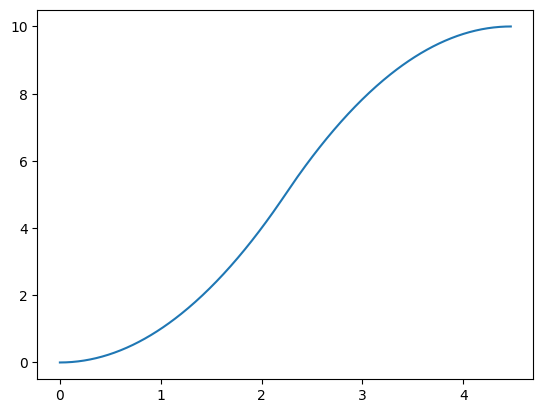

In [4]:
plt.plot(time, calculated_distances)
plt.show()

In [ ]:
l = np.diff(calculated_distances)
l = np.append(l, 0)
plt.plot(time, l)
plt.show()